=== Descriptive Statistics ===
                count        mean         std    min     25%    50%     75%  \
AQI_US           35.0   72.571429   13.419226   48.0   64.00   70.0   84.00   
PM2.5            35.0   20.554286    7.061717    8.7   15.65   19.5   26.50   
PM10             35.0   54.960000   29.924171   14.6   33.80   43.7   69.00   
O3               35.0   39.371429   17.803066   12.1   25.55   38.9   46.85   
NO2              35.0   55.602857   21.624217   19.4   44.60   52.3   68.25   
SO2              35.0    2.842857    1.301195    0.6    2.00    2.7    3.60   
CO               35.0  408.634286  183.995913  123.0  277.50  365.0  549.20   
sleep_quality    35.0   63.285714   15.388253   27.0   56.00   68.0   72.00   
time_to_sleep    35.0   28.142857   10.669205   11.0   19.50   26.0   34.50   
sleep_duration   35.0    6.900000    0.953322    5.1    6.35    7.0    7.45   

                  max  
AQI_US          102.0  
PM2.5            36.1  
PM10            146.9  
O3 

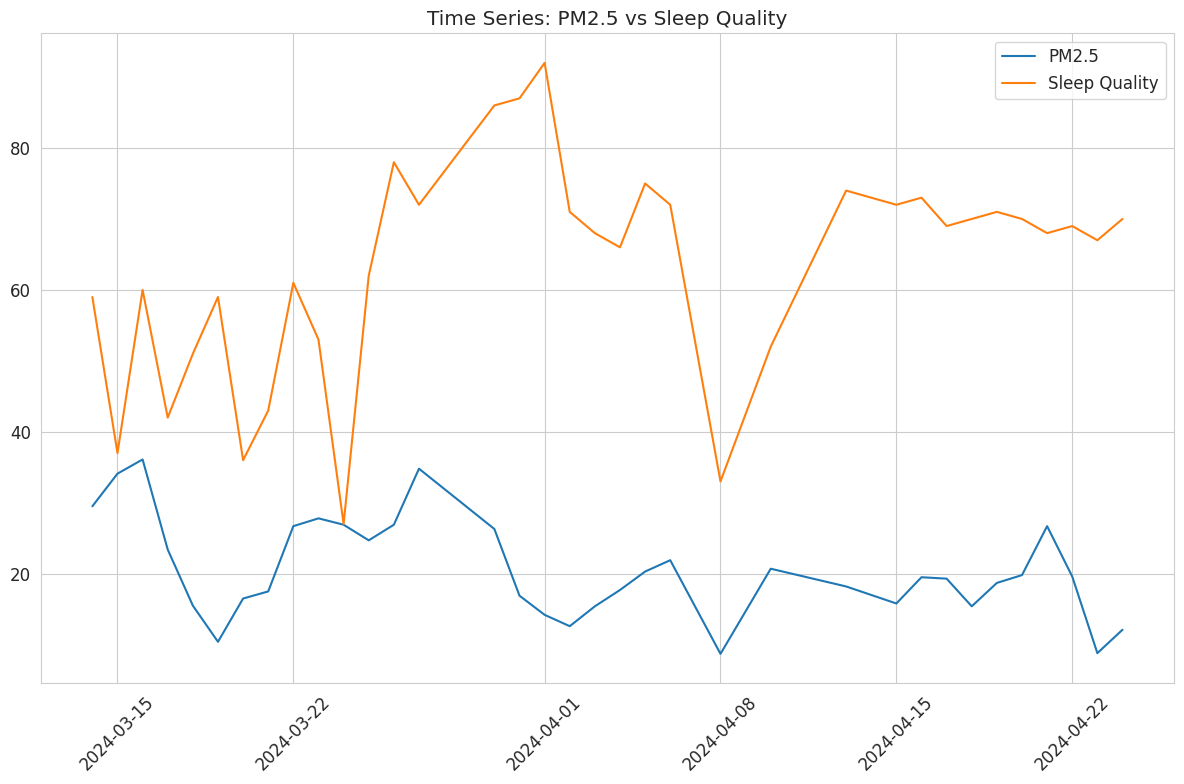

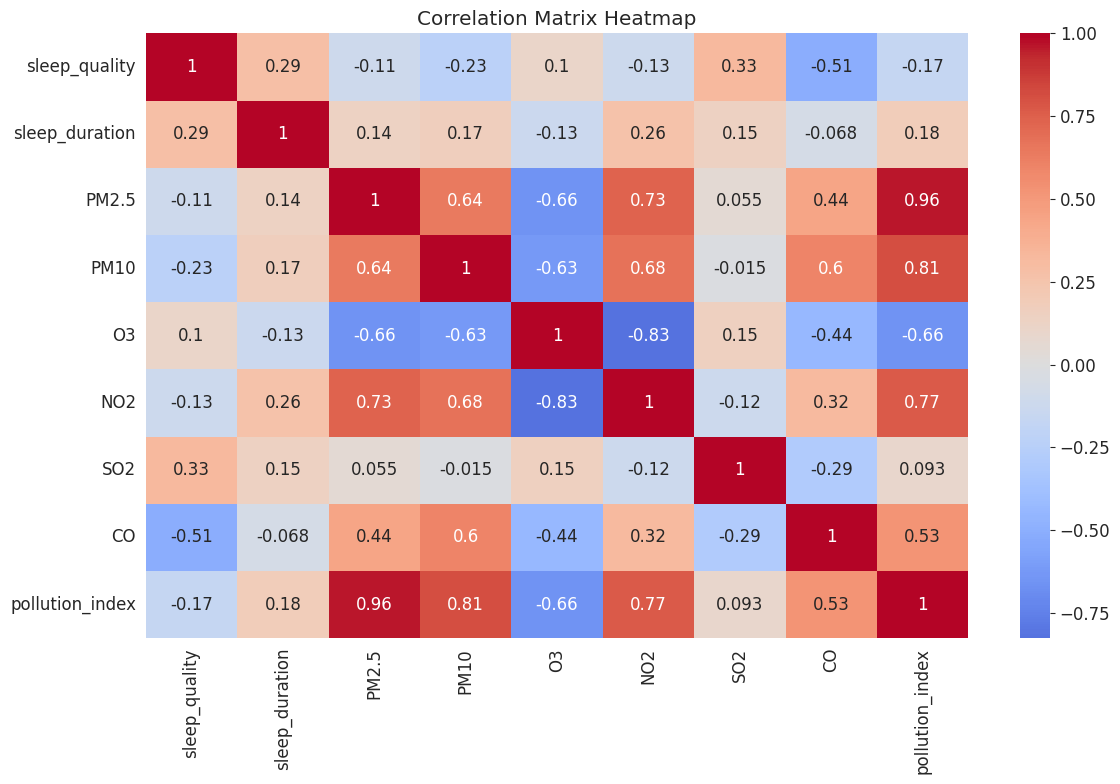

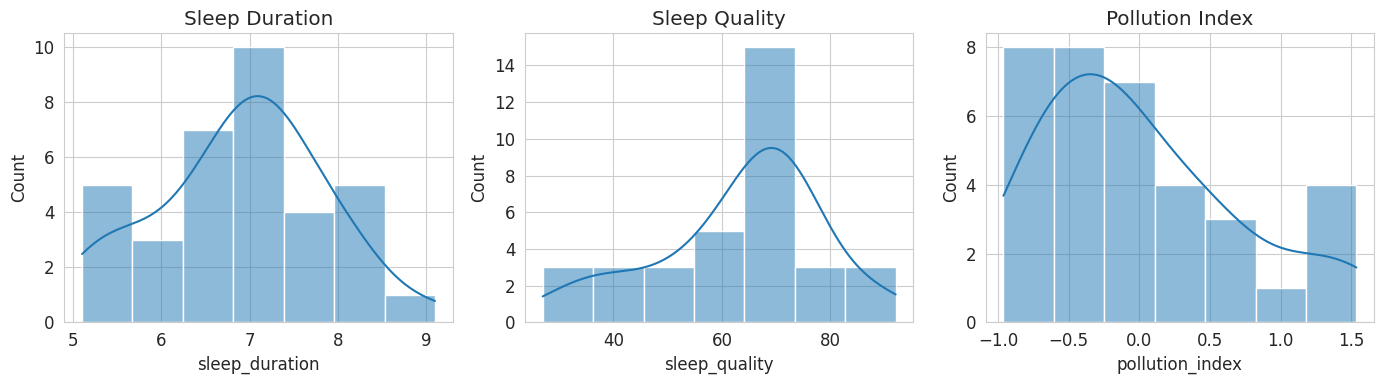

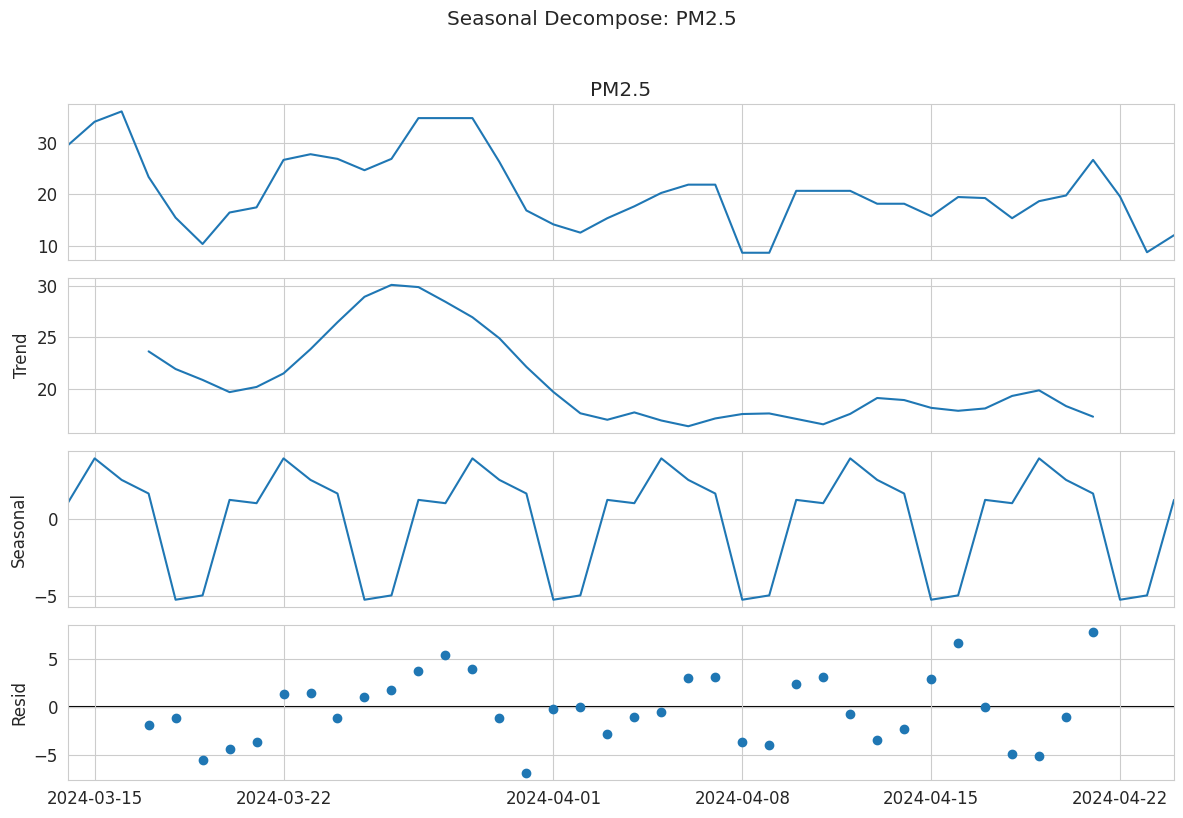

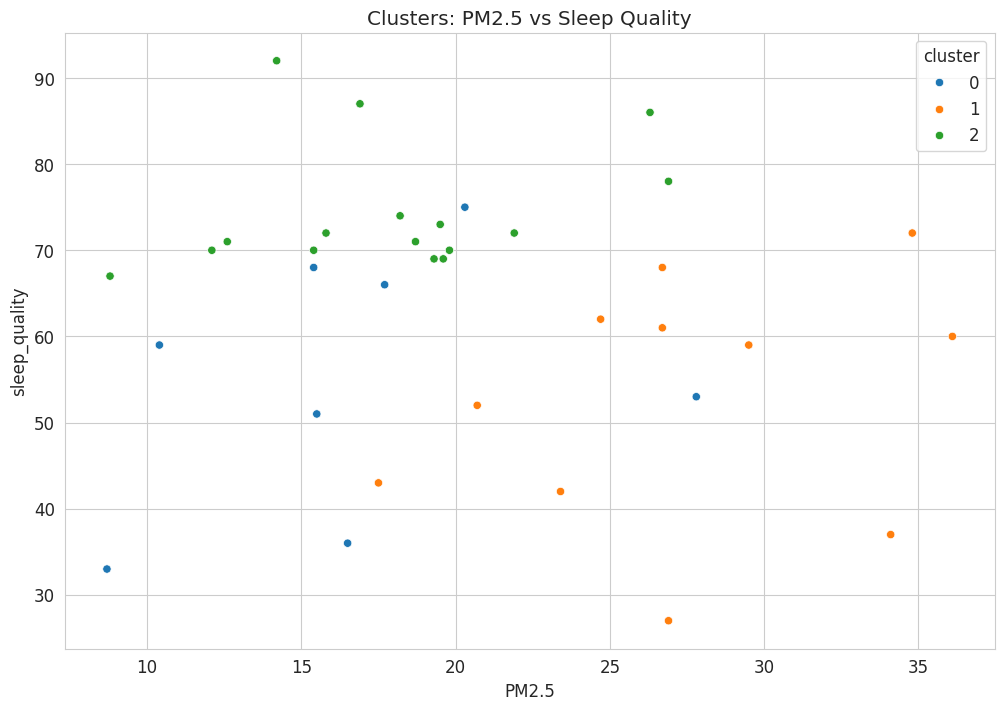


Cluster Centers:
       PM2.5  sleep_quality  sleep_duration
0  16.537500        55.1250        5.575000
1  27.372727        53.0000        7.236364
2  17.875000        74.4375        7.331250

T-Test: Weekend vs Weekday Sleep Duration -> t=0.68, p=0.507


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings


# 1. Configuration

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 2. Data Loading
data = [
    ['2024-03-14', 89, 29.5, 101.6, 24.1, 88.8, 0.7, 497.5, 59, 38, 6.1],
    ['2024-03-15', 98, 34.1, 120.6, 14.4, 101.9, 0.6, 886, 37, 19, 7.5],
    ['2024-03-16', 102, 36.1, 96.2, 21, 93.6, 1.8, 634.8, 60, 26, 8],
    ['2024-03-17', 78, 23.4, 85, 31.3, 52.3, 1.7, 575.5, 42, 19, 7.1],
    ['2024-03-18', 63, 15.5, 18.1, 44.4, 23.4, 1.5, 761.3, 51, 33, 5.3],
    ['2024-03-19', 53, 10.4, 56.4, 59.7, 19.4, 1.0, 637.4, 59, 40, 5.5],
    ['2024-03-20', 65, 16.5, 43.7, 27, 58.2, 1.5, 695.9, 36, 29, 6],
    ['2024-03-21', 67, 17.5, 48, 32.7, 60.3, 1.8, 548.4, 43, 17, 8],
    ['2024-03-22', 84, 26.7, 62.8, 15.7, 69.7, 2.0, 474.9, 61, 20, 7.3],
    ['2024-03-23', 84, 27.8, 62.9, 44.9, 51.5, 2.4, 433.6, 53, 33, 5.3],
    ['2024-03-24', 86, 26.9, 78.3, 20.7, 70.8, 3.4, 445.9, 27, 38, 7.0],
    ['2024-03-25', 84, 24.7, 88.7, 13.0, 88.1, 3.3, 569.0, 62, 19, 6.8],
    ['2024-03-26', 84, 26.9, 146.9, 12.1, 90.2, 4.4, 632.0, 78, 16, 8.0],
    ['2024-03-27', 99, 34.8, 73.1, 19.6, 82.9, 7.1, 550.0, 72, 60, 7.1],
    ['2024-03-30', 83, 26.3, 30.0, 35.3, 53.9, 2.0, 400.0, 86, 45, 8.2],
    ['2024-03-31', 66, 16.9, 31.7, 40.7, 44.1, 2.1, 246.0, 87, 22, 7.7],
    ['2024-04-01', 61, 14.2, 23.0, 33.2, 69.8, 2.2, 124.0, 92, 27, 9.1],
    ['2024-04-02', 58, 12.6, 40.1, 44.8, 53.6, 2.3, 300.0, 71, 34, 7.3],
    ['2024-04-03', 63, 15.4, 31.4, 23.6, 61.5, 2.4, 310.0, 68, 40, 5.8],
    ['2024-04-04', 67, 17.7, 40.6, 38.8, 50.3, 2.5, 320.0, 66, 42, 5.3],
    ['2024-04-05', 72, 20.3, 39.9, 34.8, 66.8, 2.6, 172.0, 75, 11, 5.1],
    ['2024-04-06', 75, 21.9, 14.6, 43.1, 60.0, 2.7, 123.0, 72, 19, 6.4],
    ['2024-04-08', 48, 8.7, 33.9, 60.9, 48.8, 2.8, 200.0, 33, 23, 6.3],
    ['2024-04-10', 73, 20.7, 30.9, 70.1, 51.4, 2.9, 230.0, 52, 25, 7.5],
    ['2024-04-13', 68, 18.2, 48.8, 45.2, 45.1, 3.0, 260.0, 74, 15, 6.8],
    ['2024-04-15', 66, 15.8, 61.5, 39.0, 51.0, 2.8, 280.0, 72, 13, 8.3],
    ['2024-04-16', 70, 19.5, 64.9, 40.3, 66.4, 3.6, 290.0, 73, 43, 7.0],
    ['2024-04-17', 70, 19.3, 38.8, 48.5, 35.6, 3.6, 275.0, 69, 30, 6.5],
    ['2024-04-18', 63, 15.4, 33.7, 53.2, 26.1, 4.1, 265.0, 70, 29, 7.1],
    ['2024-04-19', 69, 18.7, 52.5, 54.6, 31.8, 4.1, 350.0, 71, 35, 6.7],
    ['2024-04-20', 71, 19.8, 81.6, 29.6, 48.6, 4.2, 360.0, 70, 24, 6.9],
    ['2024-04-21', 84, 26.7, 40.4, 38.9, 51.9, 4.7, 365.0, 68, 26, 7.2],
    ['2024-04-22', 71, 19.6, 40.2, 70.3, 26.1, 3.6, 371.0, 69, 25, 6.6],
    ['2024-04-23', 49, 8.8, 35.8, 73.1, 27.8, 4.0, 374.0, 67, 30, 7.4],
    ['2024-04-24', 57, 12.1, 27.0, 79.4, 24.4, 4.1, 345.0, 70, 20, 7.3]
]
cols = ['date','AQI_US','PM2.5','PM10','O3','NO2','SO2','CO',
        'sleep_quality','time_to_sleep','sleep_duration']
df = pd.DataFrame(data, columns=cols)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 3. Data Cleaning & Exploration
# 3.1 Descriptive Stats
print('=== Descriptive Statistics ===')
desc = df.describe().T
print(desc)

# 3.2 Missing Values
print('\n=== Missing Values ===')
print(df.isnull().sum())

# 3.3 Outlier Detection
def detect_outliers(col):
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    return df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]

print('\n== Outliers Detected ==')
for col in df.select_dtypes(include=np.number).columns:
    outliers = detect_outliers(col)
    if not outliers.empty:
        print(f"{col}: {len(outliers)} outliers")


# 4. Feature Engineering
df['weekday'] = df.index.day_name()
df['is_weekend'] = (df.index.weekday >= 5).astype(int)

df['sleep_efficiency'] = df['sleep_quality'] / df['sleep_duration']
df['sleep_latency_hr'] = df['time_to_sleep'] / 60

# Standardize pollutants and compute weighted index
pollutants = ['PM2.5','PM10','O3','NO2','SO2','CO']
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df[pollutants])
weights = np.array([0.5, 0.2, 0.1, 0.1, 0.05, 0.05])
df['pollution_index'] = scaled_vals.dot(weights)

# Categories for PM2.5 and sleep quality
df['pm25_cat'] = pd.cut(df['PM2.5'], bins=[0,12,35,55,150],
    labels=['Good','Moderate','Unhealthy for Sensitive','Unhealthy'])
df['sleep_cat'] = pd.cut(df['sleep_quality'], bins=[0,40,60,80,100],
    labels=['Poor','Fair','Good','Excellent'])

# 5. Correlation Analysis

corr_records = []
for var in pollutants + ['pollution_index']:
    r, p = pearsonr(df[var], df['sleep_quality'])
    corr_records.append({'var': var, 'r': round(r,2), 'p_value': round(p,3)})
corr_df = pd.DataFrame(corr_records)
print('\n=== Correlation with Sleep Quality ===')
print(corr_df)

corr_matrix = df[['sleep_quality','sleep_duration'] + pollutants + ['pollution_index']].corr()


# 6. Visualization

# 6.1 Time Series: PM2.5 & Sleep Quality
plt.figure()
plt.plot(df.index, df['PM2.5'], label='PM2.5')
plt.plot(df.index, df['sleep_quality'], label='Sleep Quality')
plt.title('Time Series: PM2.5 vs Sleep Quality')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6.2 Heatmap
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


# 6.6 Histogram Distribution
plt.figure(figsize=(14,4))
for i, metric in enumerate(['sleep_duration','sleep_quality','pollution_index'], 1):
    plt.subplot(1,3,i)
    sns.histplot(df[metric], kde=True)
    plt.title(metric.replace('_',' ').title())
plt.tight_layout()
plt.show()

# 6.7 Seasonal Decomposition of PM2.5
if len(df) >= 14:
    series = df['PM2.5'].asfreq('D').fillna(method='ffill')
    result = seasonal_decompose(series, model='additive', period=7)
    result.plot()
    plt.suptitle('Seasonal Decompose: PM2.5', y=1.02)
    plt.tight_layout()
    plt.show()

# 7. Cluster Analysis
features_for_clustering = ['PM2.5', 'sleep_quality', 'sleep_duration']
X_cluster = df[features_for_clustering]

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Final Clustering when (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Plot clusters
plt.figure()
sns.scatterplot(x='PM2.5', y='sleep_quality', hue='cluster', data=df, palette='tab10')
plt.title('Clusters: PM2.5 vs Sleep Quality')
plt.show()
print('\nCluster Centers:')
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
print(pd.DataFrame(cluster_centers_original, columns=features_for_clustering))


# 8. Hypothesis Test: Weekend vs Weekday

weekend = df[df['is_weekend']==1]['sleep_duration']
weekday = df[df['is_weekend']==0]['sleep_duration']
t_stat, p_val = ttest_ind(weekend, weekday, equal_var=False)
print(f"\nT-Test: Weekend vs Weekday Sleep Duration -> t={t_stat:.2f}, p={p_val:.3f}")


# 9. Regression Analysis
X = df[['pollution_index','is_weekend']]
X = sm.add_constant(X)
y = df['sleep_quality']
model = sm.OLS(y, X).fit()